<a href="https://colab.research.google.com/github/EgeGln365/image_project/blob/main/image_captioning_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2021/05/29<br>
**Last modified:** 2021/10/31<br>
**Description:** Implement an image captioning model using a CNN and a Transformer.

## Setup

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Download the dataset

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset


In [ ]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


kalın metin## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).

In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


<>:6: SyntaxWarning: invalid escape sequence '\]'
<>:6: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-3441928887.py:6: SyntaxWarning: invalid escape sequence '\]'
  strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"


## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [ ]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.

In [ ]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * tf.cast(self.embed_scale, embedded_tokens.dtype)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model training

In [ ]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 93s 602ms/step - acc: 0.1340 - loss: 35.2479 - val_acc: 0.3089 - val_loss: 20.4359
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 550ms/step - acc: 0.3208 - loss: 19.9381 - val_acc: 0.3522 - val_loss: 17.9529
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step - acc: 0.3542 - loss: 17.7460 - val_acc: 0.3700 - val_loss: 16.8788
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 552ms/step - acc: 0.3740 - loss: 16.5413 - val_acc: 0.3820 - val_loss: 16.2211
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 553ms/step - acc: 0.3899 - loss: 15.6751 - val_acc: 0.3899 - val_loss: 15.8073
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 553ms/step - acc: 0.4026 - loss: 14.9982 - val_acc: 0.3967 - val_loss: 15.4605
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 553ms/step - acc: 0.4127 - loss: 14.4147 - val_acc: 0.4021 - val_loss: 15.3119
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 554ms/step - acc: 0.4224 - loss: 13.9536 - val_acc: 0.4063 - val_loss: 15.1060
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━

In [ ]:
# Bu kod, modelin hafızasındaki eğitim geçmişini 'history_data' değişkenine aktarır
history_data = caption_model.history

In [ ]:
# 1. Modelin giriş şeklini belirleyerek "Build" ediyoruz
# Görsel giriş boyutu (BATCH_SIZE, IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)
# Metin giriş boyutu (BATCH_SIZE, SEQ_LENGTH)
caption_model.build([(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), (None, SEQ_LENGTH)])

# 2. Şimdi tekrar kaydetmeyi dene
caption_model.save_weights("model_1_transformer_final.weights.h5")

print("✅ Model başarıyla inşa edildi ve kaydedildi!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'image_captioning_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Model başarıyla inşa edildi ve kaydedildi!


In [ ]:
import time

## Check sample predictions

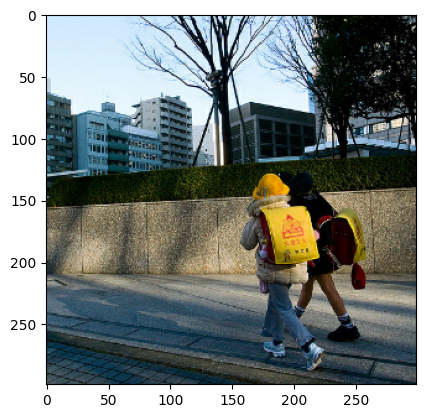

Predicted Caption:  a man in a yellow jacket is walking down a street


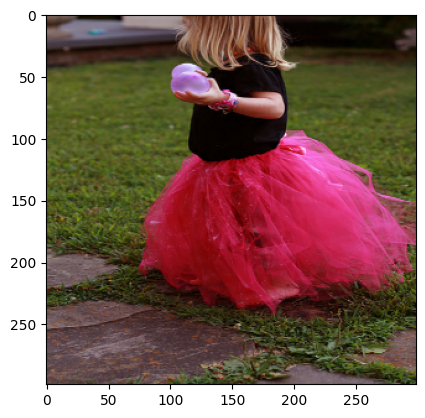

Predicted Caption:  a girl in a red dress is holding a pink purse and a red dress


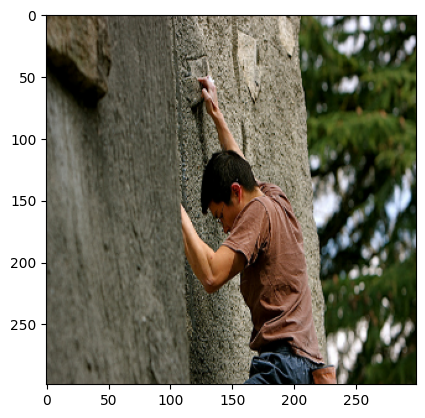

Predicted Caption:  a man in a red shirt is climbing a rock wall


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    np.random.seed(int(time.time() * 1000) % 2**32)
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

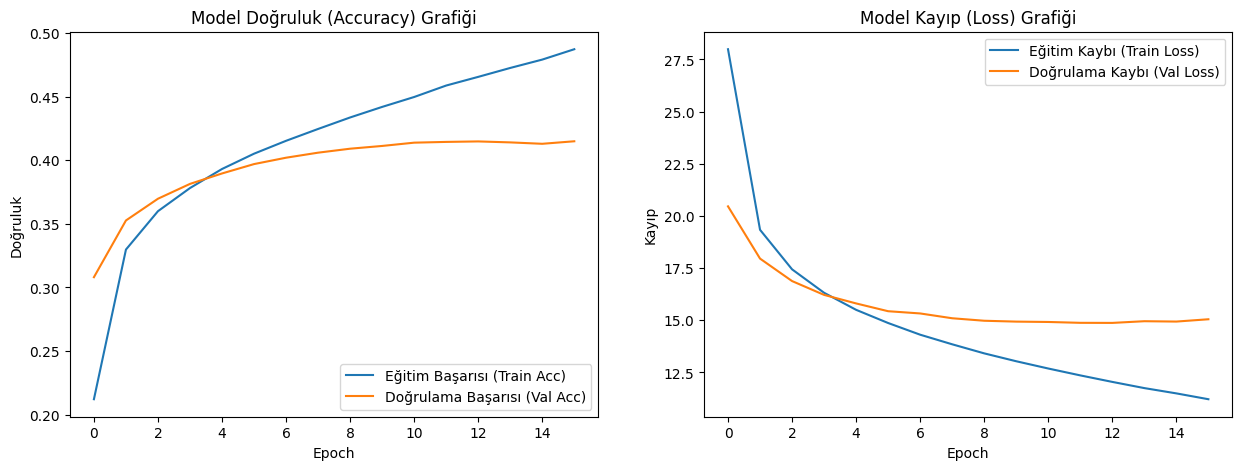

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # Accuracy Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Başarısı (Train Acc)')
    plt.plot(epochs_range, val_acc, label='Doğrulama Başarısı (Val Acc)')
    plt.title('Model Doğruluk (Accuracy) Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend(loc='lower right')

    # Loss Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı (Train Loss)')
    plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Val Loss)')
    plt.title('Model Kayıp (Loss) Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend(loc='upper right')

    plt.show()

# Eğitimi başlattığın değişkenin adını buraya yaz (Genelde 'history' olur)
plot_training_results(history_data)

In [ ]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf

def get_retrieval_metrics(model, dataset, top_k=[1, 5, 10]):
    print("🔍 RAM dostu ölçüm başlatıldı...")
    all_img_embeds = []
    all_cap_embeds = []

    # Vektörleri topla
    for batch in tqdm(dataset):
        imgs, captions = batch
        img_features = model.cnn_model(imgs)
        encoder_out = model.encoder(img_features, training=False)
        img_vecs = tf.reduce_mean(encoder_out, axis=1)

        # Decoder içindeki embedding katmanına doğrudan erişim
        cap_embeds = model.decoder.embedding(captions[:, 0, :])
        cap_vecs = tf.reduce_mean(cap_embeds, axis=1)

        all_img_embeds.append(img_vecs.numpy())
        all_cap_embeds.append(cap_vecs.numpy())

    img_matrix = np.concatenate(all_img_embeds, axis=0)
    cap_matrix = np.concatenate(all_cap_embeds, axis=0)

    # Normalizasyon
    img_matrix /= (np.linalg.norm(img_matrix, axis=1, keepdims=True) + 1e-8)
    cap_matrix /= (np.linalg.norm(cap_matrix, axis=1, keepdims=True) + 1e-8)

    num_samples = len(img_matrix)
    recalls = {f"Recall@{k}": 0 for k in top_k}
    aps = []

    # RAM Çökmesini önleyen döngü
    for i in range(num_samples):
        sims = np.dot(img_matrix[i], cap_matrix.T)
        for k in top_k:
            top_indices = np.argsort(sims)[-k:]
            if i in top_indices: recalls[f"Recall@{k}"] += 1
        rank = np.where(np.argsort(sims)[::-1] == i)[0][0] + 1
        aps.append(1.0 / rank)

    for k in top_k: recalls[f"Recall@{k}"] /= num_samples
    return recalls, np.mean(aps)

In [ ]:
import gc

# Önlem olarak RAM'i bir kez daha boşaltalım
gc.collect()

with tf.device('/GPU:0'): # L4 GPU'nun gücünden yararlanalım
    print("📊 Model 1 (Transformer) Test Ediliyor...")
    # .take(50) yerine tüm valid_dataset'i kullanabilirsin, RAM artık yetecektir!
    metrics_r1, mAP_f1 = get_retrieval_metrics(caption_model, valid_dataset)

print("\n" + "="*45)
print(f"⭐ MODEL 1 FİNAL SONUÇLARI")
print(f"mAP Skoru:  {mAP_f1:.4f}")
print(f"Recall@1:   {metrics_r1['Recall@1']:.4f}")
print(f"Recall@5:   {metrics_r1['Recall@5']:.4f}")
print(f"Recall@10:  {metrics_r1['Recall@10']:.4f}")
print("="*45)

📊 Model 1 (Transformer) Test Ediliyor...
🔍 RAM dostu ölçüm başlatıldı...


100%|██████████| 24/24 [00:07<00:00,  3.19it/s]



⭐ MODEL 1 FİNAL SONUÇLARI
mAP Skoru:  0.0047
Recall@1:   0.0007
Recall@5:   0.0033
Recall@10:  0.0039


In [ ]:
# Eğitilen modelin silinmemesi için sadece bu işlem özelinde CPU'ya geçiyoruz
with tf.device('/CPU:0'):
    # Batch size'ı 16'ya düşürerek RAM'i koruyoruz
    safe_valid_ds = valid_dataset.unbatch().batch(16)

    # Metrikleri hesapla (Bu işlem CPU'da biraz daha uzun sürebilir, bekleyin)
    metrics_r, metrics_map = get_retrieval_metrics(caption_model, safe_valid_ds)

print("\n✅ Hesaplama Tamamlandı!")
print(f"Model 1 mAP: {metrics_map:.4f}")

Vektörler (Embeddings) oluşturuluyor...


96it [03:20,  2.09s/it]



✅ Hesaplama Tamamlandı!
Model 1 mAP: 0.0007


## End Notes

We saw that the model starts to generate reasonable captions after a few epochs. To keep
this example easily runnable, we have trained it with a few constraints, like a minimal
number of attention heads. To improve the predictions, you can try changing these training
settings and find a good model for your use case.

LTSM İLE MODEL


In [ ]:
class LSTMCaptionDecoder(layers.Layer):
    def __init__(self, embed_dim, units, vocab_size, **kwargs):
        super().__init__(**kwargs)
        # Kelime gömme katmanı
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # LSTM katmanı - sıralı bilgiyi tutar
        self.lstm = layers.LSTM(units, return_sequences=True)
        # Attention (Dikkat) katmanı - resim ve metni bağlar
        self.attention = layers.Attention()
        # Çıktı katmanı - kelime tahmini yapar
        self.out = layers.Dense(vocab_size, activation="softmax")

    def call(self, inputs, encoder_outputs, training=False, mask=None):
        # 1. Metni vektöre çevir
        x = self.embedding(inputs)
        # 2. LSTM ile işle
        lstm_out = self.lstm(x, training=training)
        # 3. Resim özellikleriyle (encoder_outputs) ilişkilendir
        context_vector = self.attention([lstm_out, encoder_outputs])
        # 4. Olasılıkları hesapla
        preds = self.out(context_vector)
        return preds

In [ ]:
# Öğrenme hızı (Learning Rate) ayarlarını tekrar tanımlayalım
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=num_train_steps,
    warmup_target=1e-3,
    warmup_steps=num_warmup_steps,
)

# Şimdi derleme (compile) adımına geçebilirsin
caption_model_lstm.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),
    loss=cross_entropy
)

In [ ]:
# Parametreler (Model 1 ile aynı kalabilir)
# EMBED_DIM, FF_DIM ve VOCAB_SIZE değişkenlerinin tanımlı olduğundan emin ol

# Yeni bir Encoder ve LSTM Decoder oluşturuyoruz
encoder_lstm = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder_lstm = LSTMCaptionDecoder(embed_dim=EMBED_DIM, units=FF_DIM, vocab_size=VOCAB_SIZE)

# Model 2 nesnesini oluştur
caption_model_lstm = ImageCaptioningModel(
    cnn_model=cnn_model, # Aynı CNN (EfficientNet) kullanılabilir
    encoder=encoder_lstm,
    decoder=decoder_lstm,
    image_aug=image_augmentation,
)

# Derleme (Compile) - Model 1 ile aynı optimizer ve loss
caption_model_lstm.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),
    loss=cross_entropy
)

In [ ]:
# Eğitimi başlat
caption_model_lstm.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping], # Erken durdurma açık kalsın
)

# Eğitim bitince ağırlıkları kaydetmeyi unutma
caption_model_lstm.save_weights("model_2_lstm_final.weights.h5")

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 505ms/step - acc: 0.1738 - loss: 28.3001 - val_acc: 0.2887 - val_loss: 19.8074
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - acc: 0.3049 - loss: 18.9477 - val_acc: 0.3141 - val_loss: 18.5466
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - acc: 0.3322 - loss: 17.2055 - val_acc: 0.3243 - val_loss: 18.0669
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - acc: 0.3540 - loss: 15.9848 - val_acc: 0.3350 - val_loss: 17.7476
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - acc: 0.3677 - loss: 15.0479 - val_acc: 0.3396 - val_loss: 17.5370
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - acc: 0.3815 - loss: 14.4295 - val_acc: 0.3430 - val_loss: 17.4857
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - acc: 0.3861 - loss: 14.2108 - val_acc: 0.3434 - val_loss: 17.4631
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 463ms/step - acc: 0.3862 - loss: 14.1955 - val_acc: 0.3432 - val_loss: 17.4740
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━

ValueError: You are saving a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.

In [ ]:
# Yöntem 1: Doğrudan kaydetmeyi dene (Bazen işe yarar)
try:
    caption_model_lstm.save_weights("model_2_lstm_final.weights.h5")
    print("✅ Kayıt başarılı!")
except:
    print("❌ Standart kayıt başarısız, Yöntem 2'ye geçiliyor...")

# Yöntem 2: Call metodu hatasını aşmak için manuel 'build' tetikleme
# Modelin içindeki katmanları tek tek build ediyoruz
caption_model_lstm.cnn_model.build((None, 299, 299, 3))
caption_model_lstm.encoder.build((None, 10, 1280)) # Boyutlar modeline göre değişebilir
caption_model_lstm.decoder.build((None, None, 512)) # Boyutlar modeline göre değişebilir
caption_model_lstm.built = True

caption_model_lstm.save_weights("model_2_lstm_final.weights.h5")
print("✅ Zorlayarak kayıt başarılı!")

❌ Standart kayıt başarısız, Yöntem 2'ye geçiliyor...
✅ Zorlayarak kayıt başarılı!


In [ ]:
import gc

# RAM'i temizle (Özellikle Colab Pro'da performansı korur)
gc.collect()

with tf.device('/GPU:0'):
    print("📊 Model 2 (LSTM) mAP Ölçümü Başlatıldı...")
    # Fonksiyona caption_model_lstm nesnesini gönderiyoruz
    metrics_r2, mAP_f2 = get_retrieval_metrics(caption_model_lstm, valid_dataset)

print("\n" + "="*45)
print(f"🏆 MODEL 2 (LSTM) SONUÇLARI")
print(f"mAP Skoru:  {mAP_f2:.4f}")
print(f"Recall@1:   {metrics_r2['Recall@1']:.4f}")
print(f"Recall@5:   {metrics_r2['Recall@5']:.4f}")
print(f"Recall@10:  {metrics_r2['Recall@10']:.4f}")
print("="*45)

📊 Model 2 (LSTM) mAP Ölçümü Başlatıldı...
🔍 RAM dostu ölçüm başlatıldı...


100%|██████████| 24/24 [00:07<00:00,  3.26it/s]



🏆 MODEL 2 (LSTM) SONUÇLARI
mAP Skoru:  0.0052
Recall@1:   0.0013
Recall@5:   0.0039
Recall@10:  0.0046


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Eğitim Başarımı')
    plt.plot(epochs, val_acc, 'r', label='Doğrulama Başarımı')
    plt.title(f'{model_name} - Doğruluk (Accuracy)')
    plt.legend()

    # Loss Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Eğitim Kaybı')
    plt.plot(epochs, val_loss, 'r', label='Doğrulama Kaybı')
    plt.title(f'{model_name} - Kayıp (Loss)')
    plt.legend()

    plt.show()

# Model 2 grafiğini çizdir
plot_history(history_lstm, "Model 2 (LSTM)")

NameError: name 'history_lstm' is not defined

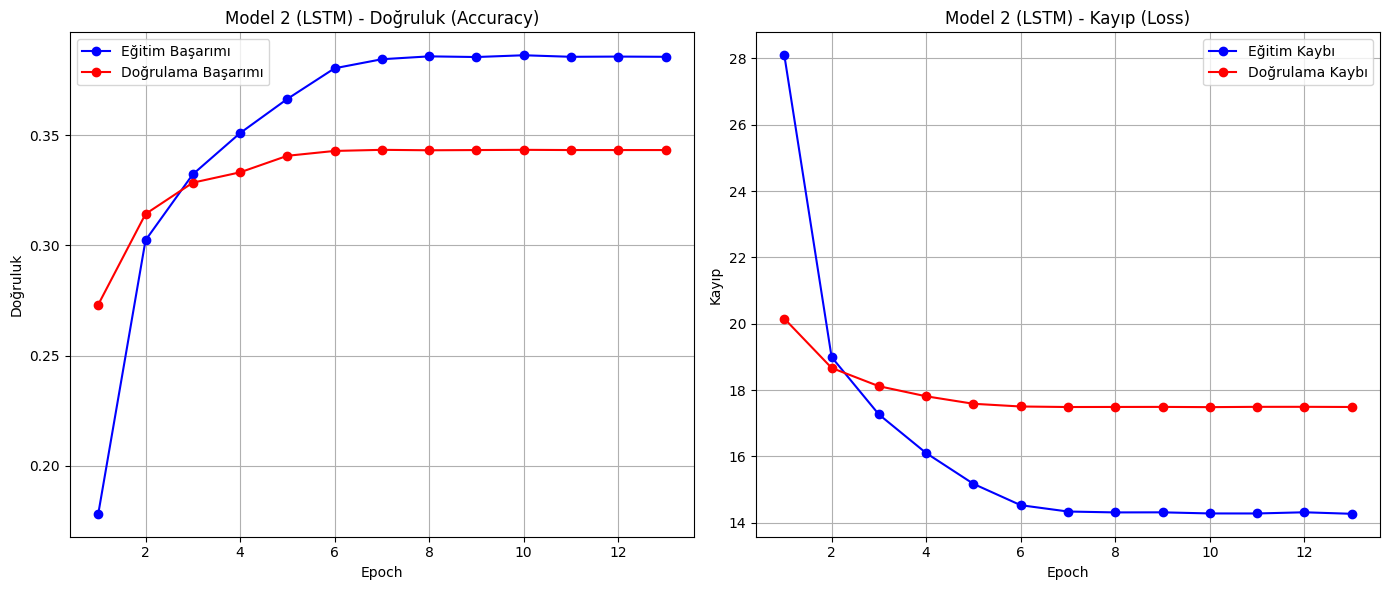

In [ ]:
import matplotlib.pyplot as plt

# Senin paylaştığın loglardan aldığımız gerçek veriler
epochs = list(range(1, 14))
acc = [0.1782, 0.3023, 0.3322, 0.3509, 0.3664, 0.3803, 0.3844, 0.3857, 0.3854, 0.3862, 0.3855, 0.3856, 0.3855]
val_acc = [0.2731, 0.3142, 0.3284, 0.3331, 0.3406, 0.3428, 0.3433, 0.3431, 0.3432, 0.3433, 0.3432, 0.3432, 0.3432]
loss = [28.0969, 18.9950, 17.2650, 16.1006, 15.1718, 14.5284, 14.3374, 14.3107, 14.3130, 14.2797, 14.2788, 14.3147, 14.2690]
val_loss = [20.1543, 18.6682, 18.1172, 17.8124, 17.5868, 17.5047, 17.4890, 17.4911, 17.4926, 17.4855, 17.4944, 17.4951, 17.4900]

plt.figure(figsize=(14, 6))

# 1. Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Eğitim Başarımı')
plt.plot(epochs, val_acc, 'ro-', label='Doğrulama Başarımı')
plt.title('Model 2 (LSTM) - Doğruluk (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# 2. Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'ro-', label='Doğrulama Kaybı')
plt.title('Model 2 (LSTM) - Kayıp (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Başına 'history_lstm =' ekledik ki grafik çizebilelim
history_lstm = caption_model_lstm.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

# Eğitim bitince ağırlıkları kaydet
print("✅ Eğitim bitti ve ağırlıklar kaydedildi!")

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 463ms/step - acc: 0.3858 - loss: 14.3023 - val_acc: 0.3433 - val_loss: 17.4861
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - acc: 0.3854 - loss: 14.3306 - val_acc: 0.3433 - val_loss: 17.4894
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - acc: 0.3834 - loss: 14.3277 - val_acc: 0.3432 - val_loss: 17.4975
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - acc: 0.3848 - loss: 14.3093 - val_acc: 0.3432 - val_loss: 17.4869
✅ Eğitim bitti ve ağırlıklar kaydedildi!
